# Classificação com conceitos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install xgboost catboost lightgbm scikit-learn matplotlib

In [ ]:
!pip install lightgbm --install-option=--gpu

In [ ]:
!apt-get install -y -qq libboost-all-dev

In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd LightGBM
!mkdir build
%cd build
!cmake -DUSE_GPU=1 ..
!make -j$(nproc)
!sudo make install
!sudo apt-get -y install python-pip
%cd ../python-package
!sudo python setup.py install --precompile

In [ ]:
import lightgbm as lgb
print('Compilado com suporte a GPU:', lgb.__file__)

In [ ]:
%cd /content/LightGBM
!mkdir build
%cd build
!cmake -DUSE_GPU=1 ..
!make -j$(nproc)
!sudo make install
!sudo ldconfig
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile


In [ ]:
import lightgbm as lgb
print('Versão do LightGBM:', lgb.__version__)
print('Caminho do pacote:', lgb.__file__)

Versão do LightGBM: 4.1.0
Caminho do pacote: /usr/local/lib/python3.10/dist-packages/lightgbm/__init__.py


In [ ]:
!nvidia-smi


NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



### Importando Bibliotecas


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import tensorflow as tf

### Função para carregar o Dataset

In [ ]:
def load_data():
    # Dummy data loading
    data = pd.read_csv('/content/drive/My Drive/0-Dataset/Projeto - Predict-Fraud - HPC/fraud_balanced.csv')
    return data

### Processando a Base de Dados

In [ ]:
def preprocess_data(data):
    label_encoder = LabelEncoder()
    data['is_fraud'] = label_encoder.fit_transform(data['is_fraud'])
    return data

### Criando o modelo

In [ ]:
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Treinando e Avaliando

In [ ]:
def train_and_evaluate(data):
    X = data.drop('is_fraud', axis=1)
    y = data['is_fraud']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        'XGBoost': xgb.XGBClassifier(tree_method='hist', use_label_encoder=False, eval_metric='logloss'),
        'RandomForest': RandomForestClassifier(),
        'LightGBM': lgb.LGBMClassifier(),
        'CatBoost': CatBoostClassifier(verbose=0),
        'Neural Network': create_model(X_train.shape[1])
    }

    results = []
    for name, model in models.items():
        start_time = time.time()
        if name == 'Neural Network':
            model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
            pred = (model.predict(X_test) > 0.5).flatten()
        else:
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
        elapsed_time = time.time() - start_time
        accuracy = accuracy_score(y_test, pred)
        f1 = f1_score(y_test, pred)

        results.append({
            'model': name,
            'time': elapsed_time,
            'accuracy': accuracy,
            'f1_score': f1
        })

    plot_results(results)

[LightGBM] [Info] Number of positive: 354272, number of negative: 354236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 708508, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500025 -> initscore=0.000102
[LightGBM] [Info] Start training from score 0.000102
5536/5536 [==============================] - 8s 1ms/step


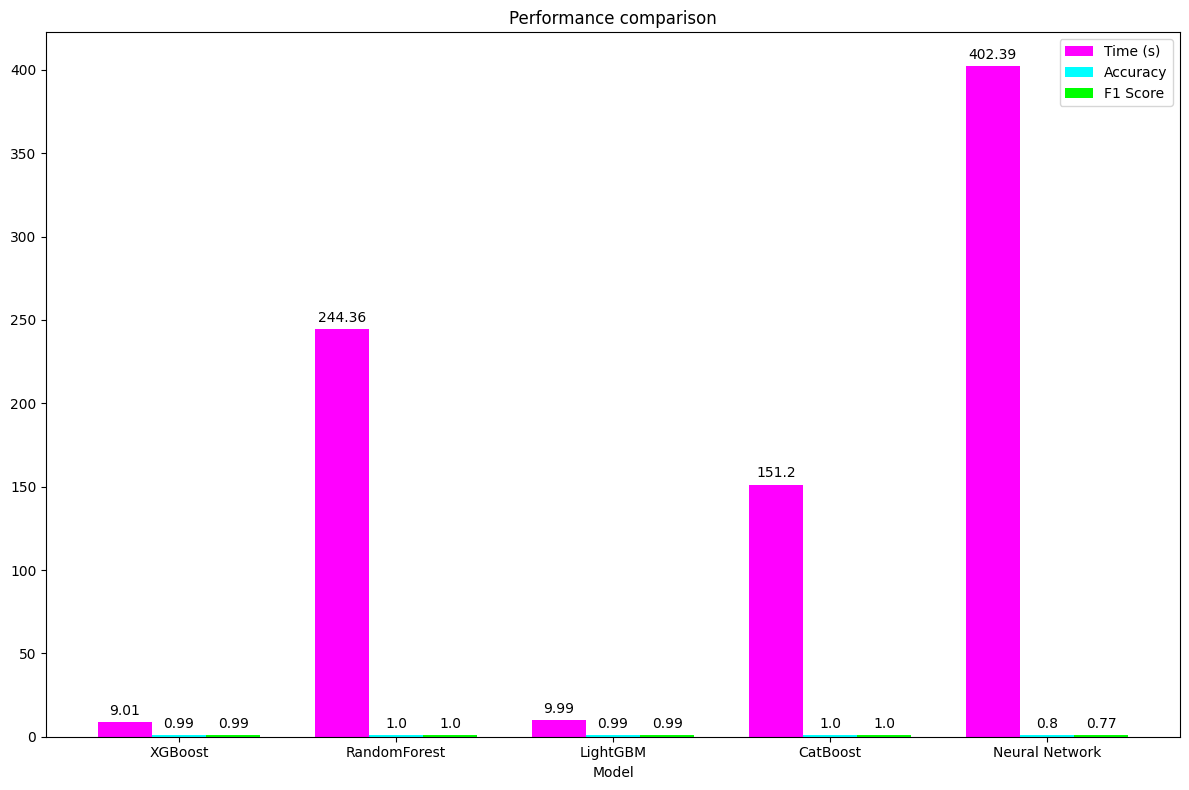

In [ ]:
def plot_results(results):
    labels = [r['model'] for r in results]
    time_vals = [r['time'] for r in results]
    accuracy_vals = [r['accuracy'] for r in results]
    f1_vals = [r['f1_score'] for r in results]

    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 8))
    rects1 = ax.bar(x - width, time_vals, width, label='Time (s)', color='magenta')
    rects2 = ax.bar(x, accuracy_vals, width, label='Accuracy', color='cyan')
    rects3 = ax.bar(x + width, f1_vals, width, label='F1 Score', color='lime')

    ax.set_xlabel('Model')
    ax.set_title('Performance comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Adding value labels on top of each bar
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_labels(rects1)
    add_labels(rects2)
    add_labels(rects3)

    fig.tight_layout()
    plt.show()

def main():
    data = load_data()
    data = preprocess_data(data)
    train_and_evaluate(data)

if __name__ == "__main__":
    main()

[LightGBM] [Info] Number of positive: 354272, number of negative: 354236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 708508, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500025 -> initscore=0.000102
[LightGBM] [Info] Start training from score 0.000102
5536/5536 [==============================] - 8s 1ms/step


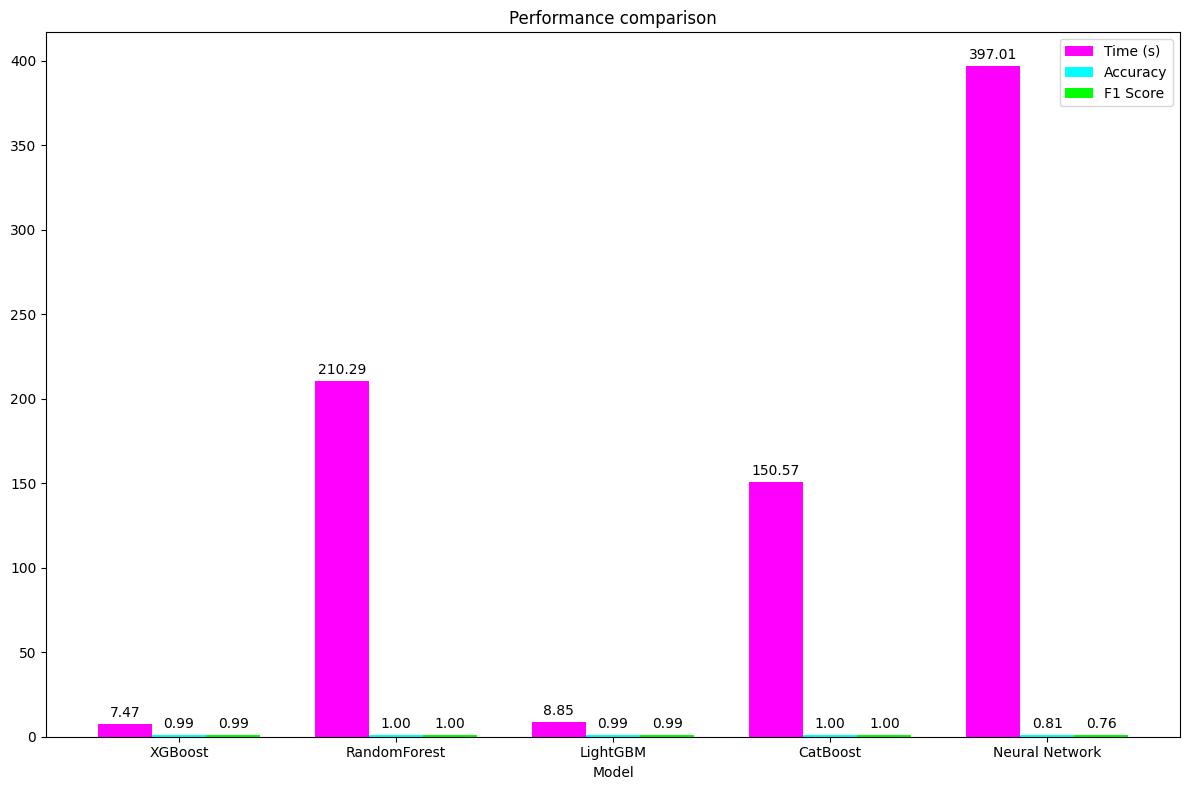

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import tensorflow as tf

def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def load_data():
    # Dummy data loading
    data = pd.read_csv('/content/drive/My Drive/0-Dataset/Projeto - Predict-Fraud - HPC/fraud_balanced.csv')
    return data

def preprocess_data(data):
    label_encoder = LabelEncoder()
    data['is_fraud'] = label_encoder.fit_transform(data['is_fraud'])
    return data

def train_and_evaluate(data):
    X = data.drop('is_fraud', axis=1)
    y = data['is_fraud']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'RandomForest': RandomForestClassifier(),
        'LightGBM': lgb.LGBMClassifier(),
        'CatBoost': CatBoostClassifier(verbose=0),
        'Neural Network': create_model(X_train.shape[1])
    }

    results = []
    for name, model in models.items():
        start_time = time.time()
        if name == 'Neural Network':
            model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
            pred = (model.predict(X_test) > 0.5).flatten()
        else:
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
        elapsed_time = time.time() - start_time
        accuracy = accuracy_score(y_test, pred)
        f1 = f1_score(y_test, pred)

        results.append({
            'model': name,
            'time': elapsed_time,
            'accuracy': accuracy,
            'f1_score': f1
        })

    plot_results(results)

def plot_results(results):
    labels = [r['model'] for r in results]
    time_vals = [r['time'] for r in results]
    accuracy_vals = [r['accuracy'] for r in results]
    f1_vals = [r['f1_score'] for r in results]

    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 8))
    rects1 = ax.bar(x - width, time_vals, width, label='Time (s)', color='magenta')
    rects2 = ax.bar(x, accuracy_vals, width, label='Accuracy', color='cyan')
    rects3 = ax.bar(x + width, f1_vals, width, label='F1 Score', color='lime')

    ax.set_xlabel('Model')
    ax.set_title('Performance comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    for rect in rects1 + rects2 + rects3:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    fig.tight_layout()
    plt.show()

def main():
    data = load_data()
    data = preprocess_data(data)
    train_and_evaluate(data)

if __name__ == "__main__":
    main()
